In [ ]:
import btk
from galcheat.utilities import mean_sky_level
import matplotlib.pyplot as plt
import numpy as np

from btk.measure import get_snr

In [ ]:
max_n_sources = 1
min_n_sources = 1 # always once source
stamp_size =  53 * 0.2 # arcsecs
max_shift = 0.0 # shift from center (so centered)
seed = 0

catalog = btk.catalog.CatsimCatalog.from_file('../../../data/OneDegSq.fits')
catalog.get_raw_catalog()['i_ab'].min()

14.3246593475

In [ ]:
sampling_function = btk.sampling_functions.DefaultSampling(
    max_number=max_n_sources,
    min_number=min_n_sources,
    stamp_size=stamp_size, 
    max_shift=max_shift, 
    min_mag = 0,  # min mag in i-band is 14.32
    max_mag = 27.3, # see document for high level responses 
    seed = seed)


In [ ]:
LSST = btk.survey.get_surveys('LSST')
i_filt = LSST.get_filter('i')

In [ ]:
# get sky level in e- counts 
sky_level = mean_sky_level('LSST', 'i').to_value('electron')

In [ ]:
i_filt.psf_fwhm

<Quantity 0.79 arcsec>

In [ ]:

batch_size = 100

draw_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    LSST,
    batch_size=batch_size,
    stamp_size=stamp_size,
    njobs=1,
    add_noise="all",
    seed=seed, # use same seed here
)


In [ ]:
batch = next(draw_generator)
batch

BlendBatch(survey_name=LSST, 
	 blend_images: np.ndarray, shape [100, 6, 53, 53]
	 isolated_images: np.ndarray, shape [100, 1, 6, 53, 53]
	 catalog_list: list of <class 'astropy.table.table.Table'>, size 100
	 psfs: list of <class 'galsim.gsobject.GSObject'>, size 6
	 wcs: <class 'astropy.wcs.wcs.WCS'>)

In [ ]:
table_to_dict(batch.catalog_list[0])

{'galtileid': tensor([402705367267]),
 'ra': tensor([0.]),
 'dec': tensor([0.]),
 'redshift': tensor([0.3142]),
 'fluxnorm_bulge': tensor([0.]),
 'fluxnorm_disk': tensor([2.1799e-18]),
 'fluxnorm_agn': tensor([0.]),
 'a_b': tensor([0.]),
 'a_d': tensor([0.9253]),
 'b_b': tensor([0.]),
 'b_d': tensor([0.6205]),
 'pa_bulge': tensor([0.]),
 'pa_disk': tensor([339.9250]),
 'u_ab': tensor([25.9116]),
 'g_ab': tensor([25.8384]),
 'r_ab': tensor([25.6581]),
 'i_ab': tensor([25.6921]),
 'z_ab': tensor([25.7327]),
 'y_ab': tensor([25.7524]),
 'x_peak': tensor([26.], dtype=torch.float64),
 'y_peak': tensor([26.0000], dtype=torch.float64),
 'btk_rotation': tensor([0.], dtype=torch.float64),
 'not_drawn_u': tensor([0.], dtype=torch.float64),
 'not_drawn_g': tensor([0.], dtype=torch.float64),
 'not_drawn_r': tensor([0.], dtype=torch.float64),
 'not_drawn_i': tensor([0.], dtype=torch.float64),
 'not_drawn_z': tensor([0.], dtype=torch.float64),
 'not_drawn_y': tensor([0.], dtype=torch.float64)}

In [ ]:
for p in batch.catalog_list[0].columns:
    print(p)

galtileid
ra
dec
redshift
fluxnorm_bulge
fluxnorm_disk
fluxnorm_agn
a_b
a_d
b_b
b_d
pa_bulge
pa_disk
u_ab
g_ab
r_ab
i_ab
z_ab
y_ab
x_peak
y_peak
btk_rotation
not_drawn_u
not_drawn_g
not_drawn_r
not_drawn_i
not_drawn_z
not_drawn_y


In [ ]:
d = dict(batch.catalog_list[0])
for p in d:
    print(d[p].value)

[402705398628]
[0.]
[0.]
[1.14676905]
[7.85807985e-19]
[3.47660082e-18]
[0.]
[0.140708]
[0.0741542]
[0.13489901]
[0.0360952]
[164.47412109]
[164.47412109]
[26.76430893]
[26.8392849]
[26.35802841]
[25.86438751]
[25.11486053]
[24.75091934]
[26.]
[26.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]


In [ ]:
snrs = get_snr(batch.isolated_images[:, 0, 3], sky_level)

23.8654327393 48.499043887065426


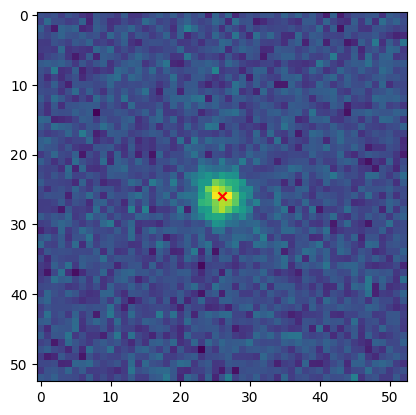

In [ ]:
idx = np.random.randint(0, 100)
plt.imshow(batch.blend_images[idx, 3]) # i-band, is indx = 3
plt.scatter(26, 26, color='r', marker='x')
print(batch.catalog_list[idx]['i_ab'].value.item(), snrs[idx])

(array([4.00000e+00, 7.00000e+00, 1.30000e+01, 1.90000e+01, 5.70000e+01,
        1.17000e+02, 2.06000e+02, 4.18000e+02, 8.79000e+02, 1.59600e+03,
        2.98700e+03, 5.26700e+03, 9.14900e+03, 1.50610e+04, 2.41320e+04,
        3.79030e+04, 5.75850e+04, 8.56110e+04, 1.21414e+05, 1.69334e+05,
        1.89156e+05, 1.30416e+05, 6.35000e+03, 4.45000e+02, 3.76000e+02]),
 array([14.32465935, 14.95125435, 15.57784935, 16.20444435, 16.83103935,
        17.45763435, 18.08422935, 18.71082436, 19.33741936, 19.96401436,
        20.59060936, 21.21720436, 21.84379936, 22.47039436, 23.09698936,
        23.72358437, 24.35017937, 24.97677437, 25.60336937, 26.22996437,
        26.85655937, 27.48315437, 28.10974937, 28.73634438, 29.36293938,
        29.98953438]),
 <BarContainer object of 25 artists>)

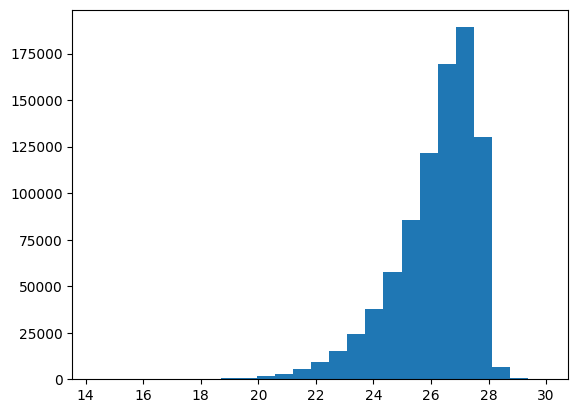

In [ ]:
plt.hist(catalog.get_raw_catalog()['i_ab'], bins=25)

In [ ]:
batch.catalog_list[0]['i_ab'].value.item()

24.3130187988